In [1]:
"""
Created on Fri Aug 30 12:34:38 2024

@author: Thierry ALLEM

" Analyse des importances des variables dans la prédictions des échanges physiques par XGBOOST global"
"""

'\nCreated on Fri Aug 30 12:34:38 2024\n\n@author: Thierry ALLEM\n\n" Analyse des importances des variables dans la prédictions des échanges physiques par XGBOOST global"\n'

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importation du fichier eco2mix_regional_def préparé, incluant les TCO, TCH, cmax_rte et les populations régionales
# Lecture du fichier CSV
df_blackout_ml = pd.read_csv('df_blackout_ML_pop.csv', sep=';',low_memory=False)
# Lecture du fichier CSV
df_blackout_ml.head()

,region,date_heure,annee,jour_numero,heure,jour_fractionnel,thermique,nucleaire,eolien,solaire,...,nucleaire_p_disp,eolien_p_disp,solaire_p_disp,cap_prod_max_hydraulique,ind_prod_hydraulique,hydraulique_p_disp,cap_prod_max_bioenergies,bioenergies_p_disp,region_p_max,population
0,CENTRE VAL DE LOIRE,2013-01-01 00:30:00,2013,1,00:30:00,1.02,90.0,9085.0,508.0,0.0,...,11630.0,662.0,207.0,91.0,0.0,91.0,41.0,41.0,12788.0,2570548
1,PAYS DE LA LOIRE,2013-01-01 00:30:00,2013,1,00:30:00,1.02,127.0,0.0,182.0,0.0,...,0.0,454.0,385.0,5.0,0.0,5.0,57.0,57.0,2738.0,3660852
2,GRAND EST,2013-01-01 00:30:00,2013,1,00:30:00,1.02,319.0,9137.0,1109.0,0.0,...,10820.0,1803.0,498.0,2280.0,0.0,2280.0,79.0,79.0,18878.0,5552388
3,ILE DE FRANCE,2013-01-01 00:30:00,2013,1,00:30:00,1.02,685.0,0.0,16.0,0.0,...,0.0,37.0,108.0,19.0,0.0,19.0,262.0,262.0,2547.0,11959807
4,OCCITANIE,2013-01-01 00:30:00,2013,1,00:30:00,1.02,78.0,2497.0,367.0,0.0,...,2620.0,861.0,1040.0,5368.0,0.0,5368.0,126.0,126.0,10260.0,5683878


In [4]:
# Filtrage des données pour les années 2013 à 2019
df_blackout_ml_13_19 = df_blackout_ml[(df_blackout_ml['annee'] >= 2013) & (df_blackout_ml['annee'] <= 2019)].copy()

In [5]:
# Conversion de la colonne 'date_heure' en datetime
df_blackout_ml_13_19['date_heure'] = pd.to_datetime(df_blackout_ml_13_19['date_heure'])

# Conversion de l'heure et des minutes en heure décimale
df_blackout_ml_13_19['heure_decimale'] = df_blackout_ml_13_19['date_heure'].dt.hour + df_blackout_ml_13_19['date_heure'].dt.minute / 60

In [6]:
# Encodages cycliques des données temporelles
df_blackout_ml_13_19['heure_decimale_sin'] = np.sin(2 * np.pi * df_blackout_ml_13_19['heure_decimale'] / 24)
df_blackout_ml_13_19['heure_decimale_cos'] = np.cos(2 * np.pi * df_blackout_ml_13_19['heure_decimale'] / 24)

In [7]:
# Fonction pour vérifier si une année est bissextile
def bissextile(annee):
    return annee % 4 == 0 and (annee % 100 != 0 or annee % 400 == 0)

In [8]:
# Ajout d'une colonne pour le nombre total de jours dans l'année en fonction de l'année
df_blackout_ml_13_19['total_jours_annee'] = df_blackout_ml_13_19['annee'].apply(lambda annee: 366 if bissextile(annee) else 365)

In [9]:
# Calcul des encodages cycliques en fonction du nombre de jours dans l'année
df_blackout_ml_13_19['jour_fractionnel_sin'] = np.sin(2 * np.pi * df_blackout_ml_13_19['jour_fractionnel'] / df_blackout_ml_13_19['total_jours_annee'])
df_blackout_ml_13_19['jour_fractionnel_cos'] = np.cos(2 * np.pi * df_blackout_ml_13_19['jour_fractionnel'] / df_blackout_ml_13_19['total_jours_annee'])

In [17]:
# Suppression de la colonne 'total_jours_annee'
df_blackout_ml_13_19 = df_blackout_ml_13_19.drop('total_jours_annee', axis=1)

In [18]:
# Afficher les colonnes pour vérifier le nom de la colonne cible
print("Colonnes disponibles dans le DataFrame :")
print(df_blackout_ml_13_19.columns)

Colonnes disponibles dans le DataFrame :
Index(['region', 'date_heure', 'annee', 'jour_numero', 'heure',
       'jour_fractionnel', 'thermique', 'nucleaire', 'eolien', 'solaire',
       'hydraulique', 'bioenergies', 'pompage', 'ech_physiques',
       'stockage_batterie', 'destockage_batterie', 'cap_prod_max_thermique',
       'thermique_p_disp', 'cap_prod_max_nucleaire', 'nucleaire_p_disp',
       'eolien_p_disp', 'solaire_p_disp', 'cap_prod_max_hydraulique',
       'ind_prod_hydraulique', 'hydraulique_p_disp',
       'cap_prod_max_bioenergies', 'bioenergies_p_disp', 'region_p_max',
       'population', 'heure_decimale', 'heure_decimale_sin',
       'heure_decimale_cos', 'jour_fractionnel_sin', 'jour_fractionnel_cos'],
      dtype='object')


In [19]:
# ********************  ENTRAINEMENT DU MODELE  ****************************************

# Encodage de'region' sans créer de colonnes séparées
label_encoder = LabelEncoder()
df_blackout_ml_13_19['region_encoded'] = label_encoder.fit_transform(df_blackout_ml_13_19['region'])

# Sélection des caractéristiques sans ventiler 'region'
features = df_blackout_ml_13_19[['region_encoded', 'annee', 'jour_fractionnel_sin', 'jour_fractionnel_cos', 
                                   'heure_decimale_sin', 'heure_decimale_cos', 'thermique', 'nucleaire', 
                                   'eolien', 'solaire', 'hydraulique', 'bioenergies', 'pompage', 
                                   'stockage_batterie', 'destockage_batterie', 'cap_prod_max_thermique', 
                                   'thermique_p_disp', 'cap_prod_max_nucleaire', 'nucleaire_p_disp', 
                                   'cap_prod_max_hydraulique', 'hydraulique_p_disp', 'cap_prod_max_bioenergies',
                                   'bioenergies_p_disp', 'solaire_p_disp', 'eolien_p_disp', 'population']]

target_variable = 'ech_physiques'
y = df_blackout_ml_13_19[target_variable]
X = features  # On garde X sans la colonne cible

# Entraînement du modèle XGBoost
xgb_model_global = XGBRegressor()
xgb_model_global.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [20]:
# Visualisation de l'importance des caractéristiques
def plot_feature_importance(model, features_encoded, filename):
    # Récupération de l'importance des caractéristiques
    importances = model.feature_importances_
    feature_names = features_encoded.columns
    
    # Création d'un DataFrame pour l'importance des caractéristiques
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Tri des caractéristiques par importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Création du graphique
    plt.figure(figsize=(12, 8))
    bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')

    # Ajout de labels et titre
    plt.xlabel('Importance')
    plt.ylabel('Variables explicatives')
    plt.title('Importance des variables explicatives - XGBoost global')

    # Affichage des valeurs sur les barres
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', 
                 va='center', ha='left', fontsize=10, color='black')

    # Enregistrement du graphique
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

    return feature_importance_df

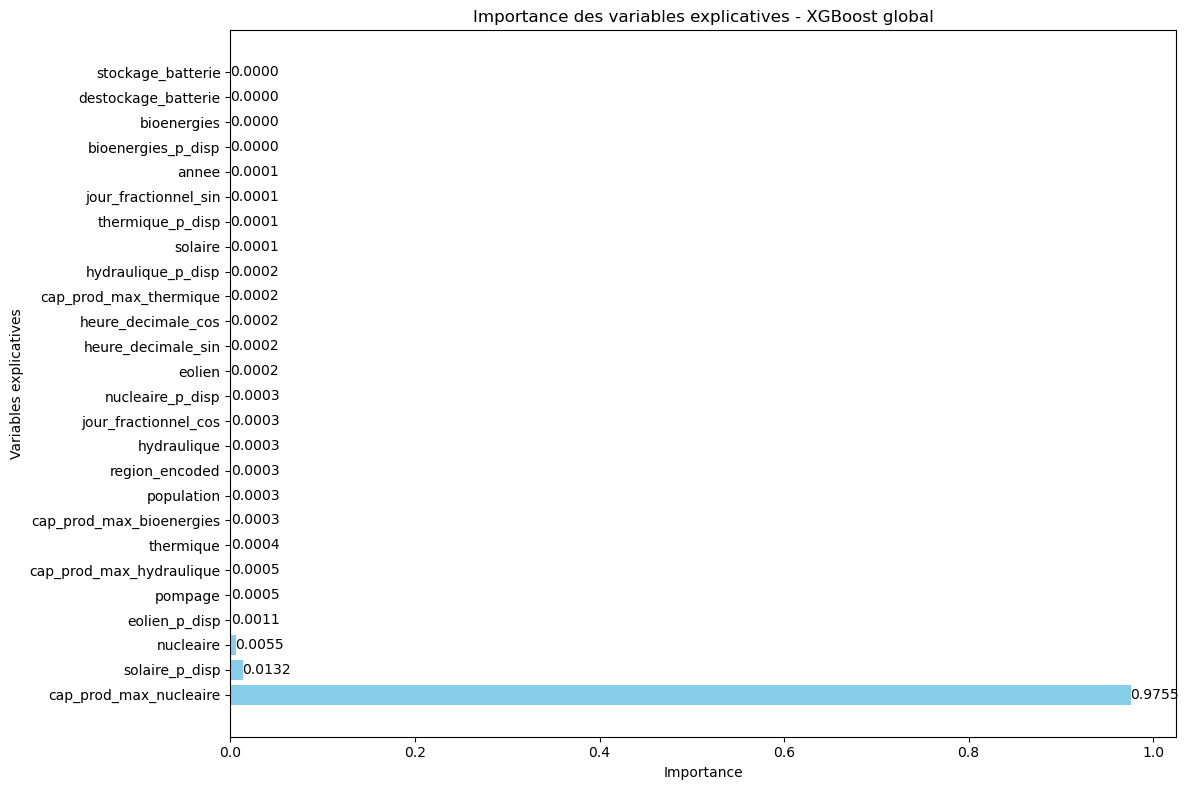

In [21]:
# Visualisation de l'importance des variables explicatives
feature_importance_df = plot_feature_importance(xgb_model_global, X, 'importance_features_XGB_global.png')

In [22]:
# Enregistrement des importances dans un fichier CSV
feature_importance_df.to_csv('importance_features_XGB_global.csv', index=False)